# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
## YOUR CODE HERE ##
train_transform = T.Compose([T.RandomRotation(45),
                             T.RandomVerticalFlip(p=0.3),
                             T.Resize(224),
                             T.ToTensor(),
                             T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])])

test_transform = T.Compose([T.Resize(224),
                            T.ToTensor(),
                            T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])])

# Create training set and define training dataloader
## YOUR CODE HERE ##
import torchvision.datasets as datasets

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        std = [0.247, 0.243, 0.261] 
        mean = [0.491, 0.482, 0.447]
        for j in range(3):
            image[j] = std[j] * images[i][j] + mean[j]
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

horse


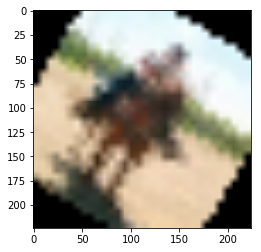

car


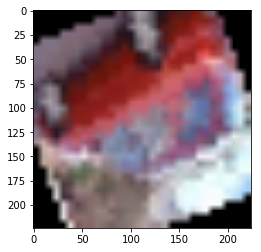

ship


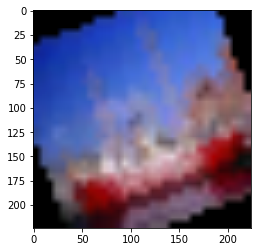

deer


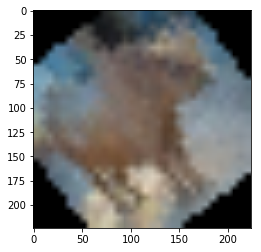

ship


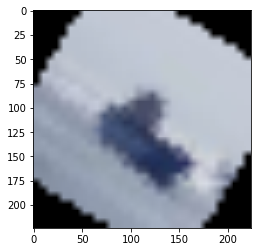

In [5]:
show5(trainloader)

In [6]:
# Explore data
## YOUR CODE HERE ##
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

# Size of train and test datasets
print(f'Size of Train Dataset: {len(trainset)}')
print(f'Size of Test Dataset: {len(testset)}')

torch.Size([64, 3, 224, 224])
torch.Size([64])
Size of Train Dataset: 50000
Size of Test Dataset: 10000


- The original image size (32 x 32 x 3) is resized to 224 x 224 x 3 which is the default input size of resnet50 that I will use. 
- The datasets have 3 color channels. 
- The batch size is set at 64.
- The train dataset has 50,000 images and the test dataset has 10,000 images. 

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [7]:
## YOUR CODE HERE ##
from torchvision import models

model = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 85907207.16it/s]


In [8]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 128),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(128, 10),
                         nn.LogSoftmax(dim=1))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss()

params_group = [{'params': model.layer1.parameters(), 'lr': 0.0001},
                {'params': model.layer2.parameters(), 'lr': 0.0001},
                {'params': model.layer3.parameters(), 'lr': 0.0001}, 
                {'params': model.layer4.parameters(), 'lr': 0.0001},
                {'params': model.fc.parameters(), 'lr': 0.0005}]
optimizer = optim.Adam(params_group)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
## YOUR CODE HERE ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [12]:
epochs = 2
steps = 0
train_loss = 0
print_every = 20

train_losses, test_losses, accuracies = [], [], []

for epoch in range(epochs):  
  for images, labels in trainloader:
      steps += 1
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item()
      
      if steps % print_every == 0:
          test_loss = 0
          accuracy = 0
          model.eval()
          with torch.no_grad():
              for images, labels in testloader:
                  images, labels = images.to(device), labels.to(device)

                  output = model.forward(images)
                  test_loss += criterion(output, labels).item()
                  
                  ps = torch.exp(output)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {train_loss/print_every:.3f}.. "
                f"Test loss: {test_loss/len(testloader):.3f}.. "
                f"Test accuracy: {accuracy/len(testloader):.3f}") 
          
          train_losses.append(train_loss/print_every)
          test_losses.append(test_loss/len(testloader))
          accuracies.append(accuracy/len(testloader))
          train_loss=0
          model.train()

Epoch 1/2.. Train loss: 1.989.. Test loss: 1.686.. Test accuracy: 0.319
Epoch 1/2.. Train loss: 1.384.. Test loss: 1.275.. Test accuracy: 0.490
Epoch 1/2.. Train loss: 1.199.. Test loss: 0.862.. Test accuracy: 0.682
Epoch 1/2.. Train loss: 1.135.. Test loss: 0.692.. Test accuracy: 0.748
Epoch 1/2.. Train loss: 1.047.. Test loss: 0.693.. Test accuracy: 0.733
Epoch 1/2.. Train loss: 0.926.. Test loss: 0.588.. Test accuracy: 0.791
Epoch 1/2.. Train loss: 0.926.. Test loss: 0.669.. Test accuracy: 0.766
Epoch 1/2.. Train loss: 0.933.. Test loss: 0.573.. Test accuracy: 0.781
Epoch 1/2.. Train loss: 0.908.. Test loss: 0.565.. Test accuracy: 0.814
Epoch 1/2.. Train loss: 0.966.. Test loss: 0.600.. Test accuracy: 0.805
Epoch 1/2.. Train loss: 0.915.. Test loss: 0.463.. Test accuracy: 0.848
Epoch 1/2.. Train loss: 0.896.. Test loss: 0.492.. Test accuracy: 0.838
Epoch 1/2.. Train loss: 0.851.. Test loss: 0.509.. Test accuracy: 0.828
Epoch 1/2.. Train loss: 0.789.. Test loss: 0.497.. Test accuracy

Plot the training loss (and validation loss/accuracy, if recorded).

Text(0,0.5,'Losses')

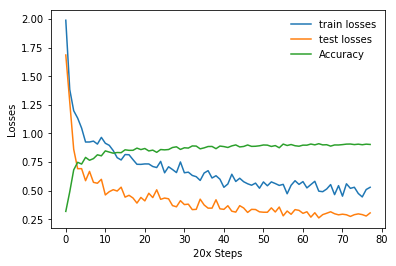

In [13]:
## YOUR CODE HERE ##
# Training and testing losses are plotted together.

fig, ax = plt.subplots()
ax.plot(train_losses, label="train losses")
ax.plot(test_losses, label ="test losses")
ax.plot(accuracies, label = "Accuracy")
ax.legend(frameon=False)
ax.set_xlabel('20x Steps')
ax.set_ylabel('Losses')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##
# SEE ABOVE. Training and testing were done more simultaneously.

- At the end of Epoch 2, the model achieved around 90.7% accuracy (best at 91.1%). As shown in the graph above, the losses and accuracy plataued at the end of Epoch 2. 
- It is interesting to see that the training losses trend bigger than the testing losses. I guess it does have a good generalization and definitely avoided the overfitting. However, I had expected those losses would be similar or training losses to be smaller. To be honest, I don't have an explanation why training losses are bigger than testing losses. 

## Saving your model
Using `torch.save`, save your model for future loading.

In [19]:
## YOUR CODE HERE ##
checkpoint = {'model': model, 'epoch': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict()
             }
torch.save(checkpoint, 'up2_rn50.pth')


NOTE: I wish there was more guidance on saving the models, especially when using the Transfer Learning pre-trained models. I don't believe what I saved captured all I needed to load later. I looked up all over the websites to find more information on how to do this, and couldn't find much.

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

- My model performs much better than Detectorcorp's model, with an accuracy above 90% compared to Detectorcorp's 70%. I would recommend using my model instaed of purchasing Detectocorp's model. 
- Accuracy-wise, it is very close to Maxout Networks, which has 90.6% accuracy rate. My model beats Deep Belief Networks, but isn't as good as the more recent models such as Wide Residual, GPipe, and Rethinking Recurrent NNs. 
- I tried different Transfer Learning models, and also built my own Convolutional NNs. I found that the deeper layers pre-trained models were very time consuming, but not necessarily better in this case. My own CNNs performed around 70%, not good enough. I fianally chose resnet50 for its efficiency and known performance. I re-trained the parameters of the resnet with very low learning rates. I used dropouts for the last fully connected layers, which replaced the original resnet fc layers.
- I only ran up to 2 epochs due to the time limits. It would be ideal to go up to epoch 3, although the values started platauing. Trying with slightly higher learn rate would be interesting. Increasing fc layers with more neurons or additional layers would be another option. But I am not sure if I can get a lot of imorovement from where it is. 




## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).